## Assignment 7 
### Feature importance

In this assignment, the HTRU2 dataset is used that can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/HTRU2).

In this workbook, feature importance techniques are implemented.

In [1]:
# if needed install packages uncommenting the following commands
# !pip install shap
# !pip install eli5
# !pip install xgboost

### Introduction
Pulsars are a rare type of Neutron star that produce radio emission detectable here on Earth. They are of considerable scientific interest as probes of space-time, the inter-stellar medium, and states of matter.  
As pulsars rotate, their emission beam sweeps across the sky, and when this crosses our line of sight, produces a detectable pattern of broadband radio emission. As pulsars rotate rapidly, this pattern repeats periodically. Thus pulsar search involves looking for periodic radio signals with large radio telescopes.  
Each pulsar produces a slightly different emission pattern, which varies slightly with each rotation. Thus a potential signal detection known as a 'candidate', is averaged over many rotations of the pulsar, as determined by the length of an observation. In the absence of additional info, each candidate could potentially describe a real pulsar. However in practice almost all detections are caused by radio frequency interference (RFI) and noise, making legitimate signals hard to find.


<img src="https://www.sciencealert.com/images/2020-01/processed/pulsar-art_1024.jpg" width=1300 height=400 />

In [3]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, plot_roc_curve
from xgboost import XGBClassifier
import shap
import eli5
from eli5.sklearn import PermutationImportance
import os 

os.chdir('C:/Users/anast/OneDrive/Desktop/MSc/MachineLearning/Assignments/Asgmt7_FeatureSelection/')

In [4]:
data_file = 'HTRU2/HTRU_2.csv'

data = pd.read_csv(data_file, header=None)


feature_names = ["Mean of the integrated profile",
	"Standard deviation of the integrated profile",
	"Excess kurtosis of the integrated profile",
	"Skewness of the integrated profile",
	"Mean of the DM-SNR curve",
	"Standard deviation of the DM-SNR curve",
	"Excess kurtosis of the DM-SNR curve",
	"Skewness of the DM-SNR curve"]

data.columns = feature_names + ["target_class"]

In [5]:
# check for missing data
if data.isnull().any().sum() > 0:
    plt.figure(figsize=(8,6))
    sns.heatmap(data.isnull(), cmap='gnuplot', yticklabels=False, cbar=False)
    plt.title('Missing values on HTRU2')
    plt.show()
else:
    print('There are no missing values in the data')

There are no missing values in the data


In [6]:
# Run on colab
# plt.figure(figsize=(16,14))
# sns.pairplot(data=data, hue='target_class', palette=['darkorange', 'indigo'])
# plt.suptitle('Pairplot of predictor variables of HTRU2 dataset')
# plt.tight_layout()
# plt.show()

In [7]:
# split in train-test set in a stratified manner

X = data.drop(columns = 'target_class')
y = data['target_class'].astype(int)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=556, stratify=y)

In [8]:
scaler = MinMaxScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Feature importance

Feature importance refers to a class of techniques for assigning scores to input features to a predictive model that indicates the relative importance of each feature when making a prediction.

For the initial models trained with all the features an AUC curve is provided.  

### Coefficients as feature importance

Linear machine learning algorithms fit a model where the prediction is the weighted sum of the input values.  
All of these algorithms find a set of coefficients to use in the weighted sum in order to make a prediction. These coefficients can be used directly as a crude type of feature importance score.

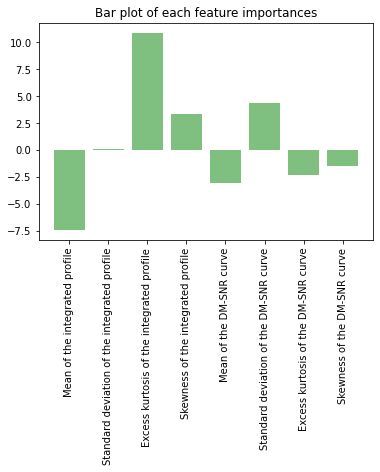

In [9]:
clf_full = LogisticRegression(random_state=119)

clf_full.fit(X_train, y_train)
lg_importance = clf_full.coef_


plt.bar(x=feature_names, height=lg_importance[0], alpha=0.5, color='green')
plt.xticks(rotation=90)
plt.title('Bar plot of each feature importances')
plt.show()

In [10]:
feat_importance = sorted([(i,abs(x)) for i,x in enumerate(lg_importance[0])], key=lambda x:x[1], reverse=True)
select4 = [x[0] for x in feat_importance[:4]]
select6 = [x[0] for x in feat_importance[:6]]

feature_importance = '\n'.join([feature_names[x[0]] for x in feat_importance])
print('Feature importance in decreasing order:')
print(feature_importance)

Feature importance in decreasing order:
Excess kurtosis of the integrated profile
Mean of the integrated profile
Standard deviation of the DM-SNR curve
Skewness of the integrated profile
Mean of the DM-SNR curve
Excess kurtosis of the DM-SNR curve
Skewness of the DM-SNR curve
Standard deviation of the integrated profile


In [11]:
def print_metrics(num_vars, model_name, y_test, predictions):  
    print(f'Using {num_vars} variables, the metrics for the {model_name} model are: \nAccuracy {accuracy_score(y_test, predictions)*100:.2f}%'
            f'\nPrecision {precision_score(y_test, predictions)*100:.2f}% '
            f'\nRecall {recall_score(y_test, predictions)*100:.2f}% '
            f'\nF1 {f1_score(y_test, predictions)*100:.2f}% ')

predictions = clf_full.predict(X_test)
print_metrics('all', 'Logistic Regression', y_test, predictions)

Using all variables, the metrics for the Logistic Regression model are: 
Accuracy 97.46%
Precision 95.36% 
Recall 75.97% 
F1 84.57% 


In [12]:
clf4 = LogisticRegression(random_state=119)
clf4 .fit(X_train[:, select4], y_train)
predictions4 = clf4 .predict(X_test[:, select4])
print_metrics(4, 'Logistic Regression', y_test, predictions4)

Using 4 variables, the metrics for the Logistic Regression model are: 
Accuracy 97.19%
Precision 93.71% 
Recall 74.31% 
F1 82.89% 


In [13]:
clf6 = LogisticRegression(random_state=119)
clf6.fit(X_train[:, select6], y_train)
predictions6 = clf6.predict(X_test[:, select6])
print_metrics(6, 'Logistic Regression', y_test, predictions6)

Using 6 variables, the metrics for the Logistic Regression model are: 
Accuracy 97.44%
Precision 95.14% 
Recall 75.97% 
F1 84.48% 


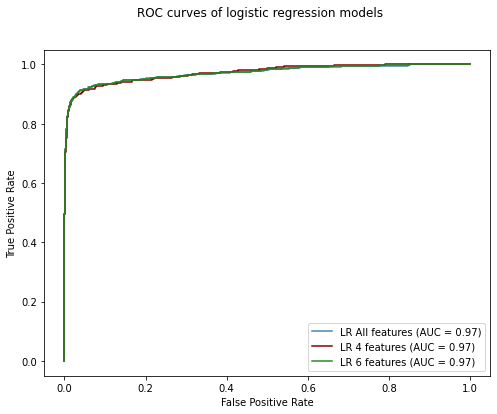

In [14]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey='row')
plt.suptitle('ROC curves of logistic regression models')
plot_roc_curve(clf_full, X_test, y_test, color='steelblue', ax=axs, name='LR All features')
plot_roc_curve(clf4, X_test[:, select4], y_test, color='maroon', ax=axs, name='LR 4 features')
plot_roc_curve(clf6, X_test[:, select6], y_test, color='forestgreen', ax=axs, name='LR 6 features')
plt.show()

### Tree-based algorithms Feature importance

In XGBoost importance provides a score that indicates how useful or valuable each feature was in the construction of the boosted decision trees within the model. The more an attribute is used to make key decisions with decision trees, the higher its relative importance.

*Importance is calculated for a single decision tree by the amount that each attribute split point improves the performance measure, weighted by the number of observations the node is responsible for.*

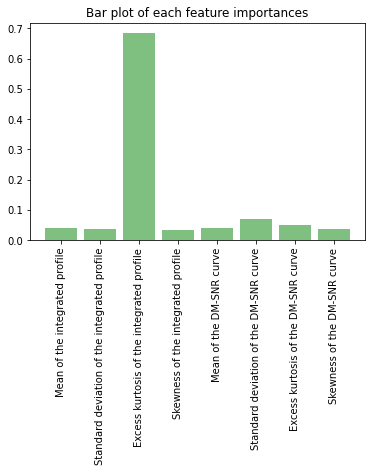

In [15]:
clf_full = XGBClassifier(random_state=546)

clf_full.fit(X_train, y_train)
xgb_importance = clf_full.feature_importances_


plt.bar(x=feature_names, height=xgb_importance, alpha=0.5, color='green')
plt.xticks(rotation=90)
plt.title('Bar plot of each feature importances')
plt.show()

Another method to compute feature importance in Xgboost (and other ensemble tree models) is to use [SHAP](https://shap.readthedocs.io/en/latest/) package. It is model-agnostic and using the [Shapley values](https://christophm.github.io/interpretable-ml-book/shapley.html) from game theory to estimate how each feature contributes to the prediction.

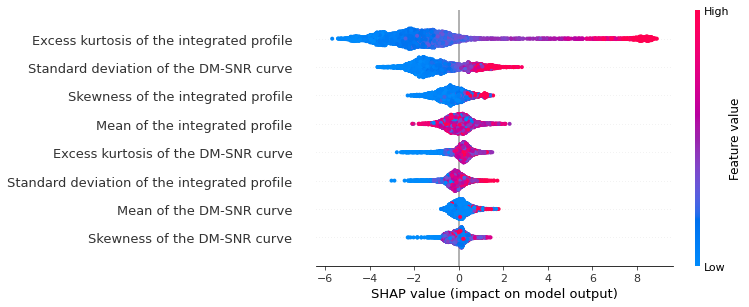

In [16]:
explainer = shap.TreeExplainer(clf_full)
shap_values = explainer.shap_values(X_test)

plt.figure(figsize=(14,4))
shap.summary_plot(shap_values, X_test, feature_names=feature_names)
plt.show()

In [17]:
feat_importance = sorted([(i,x) for i,x in enumerate(xgb_importance)], key=lambda x:x[1], reverse=True)
select4 = [x[0] for x in feat_importance[:4]]
select6 = [x[0] for x in feat_importance[:6]]

feature_importance = '\n'.join([feature_names[x[0]] for x in feat_importance])
print('Feature importance in decreasing order:')
print(feature_importance)

Feature importance in decreasing order:
Excess kurtosis of the integrated profile
Standard deviation of the DM-SNR curve
Excess kurtosis of the DM-SNR curve
Mean of the DM-SNR curve
Mean of the integrated profile
Standard deviation of the integrated profile
Skewness of the DM-SNR curve
Skewness of the integrated profile


In [18]:
predictions = clf_full.predict(X_test)
print_metrics('all', 'XGBoost Classifier', y_test, predictions)

Using all variables, the metrics for the XGBoost Classifier model are: 
Accuracy 98.17%
Precision 93.04% 
Recall 86.51% 
F1 89.66% 


In [19]:
clf4 = XGBClassifier(random_state=546)
clf4.fit(X_train[:, select4], y_train)
predictions = clf4.predict(X_test[:, select4])
print_metrics(4, 'Logistic Regression', y_test, predictions)

Using 4 variables, the metrics for the Logistic Regression model are: 
Accuracy 97.85%
Precision 89.96% 
Recall 86.14% 
F1 88.01% 


In [20]:
clf6 = XGBClassifier(random_state=546)
clf6.fit(X_train[:, select6], y_train)
predictions = clf6.predict(X_test[:, select6])
print_metrics(6, 'Logistic Regression', y_test, predictions)

Using 6 variables, the metrics for the Logistic Regression model are: 
Accuracy 98.05%
Precision 92.26% 
Recall 85.95% 
F1 89.00% 


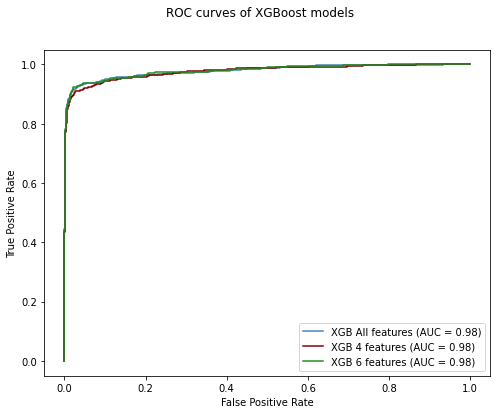

In [21]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey='row')
plt.suptitle('ROC curves of XGBoost models')
plot_roc_curve(clf_full, X_test, y_test, color='steelblue', ax=axs, name='XGB All features')
plot_roc_curve(clf4, X_test[:, select4], y_test, color='maroon', ax=axs, name='XGB 4 features')
plot_roc_curve(clf6, X_test[:, select6], y_test, color='forestgreen', ax=axs, name='XGB 6 features')
plt.show()

### Permutation Feature Importance

Permutation feature importance measures the increase in the prediction error of the model after we permuted the feature's values, which breaks the relationship between the feature and the true outcome.  
The concept is really straightforward: We measure the importance of a feature by calculating the increase in the model's prediction error after permuting the feature. A feature is "important" if shuffling its values increases the model error, because in this case the model relied on the feature for the prediction. A feature is "unimportant" if shuffling its values leaves the model error unchanged, because in this case the model ignored the feature for the prediction. 

More detailed [here](https://christophm.github.io/interpretable-ml-book/feature-importance.html).

Permutation importance is calculated using [eli5](https://eli5.readthedocs.io/en/latest/) library. The output is in HTML format, therefore it can only be used in an ipython notebook.    
**Fun Fact!** Eli5 is named after the slang "Explain it like I'm 5!".

In [22]:
clf_full = RandomForestClassifier(n_estimators=100, random_state=119)

clf_full.fit(X_train, y_train)
predictions = clf_full.predict(X_test)
print_metrics('all', 'Random Forest', y_test, predictions)

Using all variables, the metrics for the Random Forest model are: 
Accuracy 98.12%
Precision 93.17% 
Recall 85.77% 
F1 89.32% 


In [23]:
permuter = PermutationImportance(clf_full, cv='prefit', scoring='recall', n_iter=5, random_state=42)
permuter.fit(X_test, y_test)

eli5.show_weights(permuter, feature_names=[f'{i+1}_{name}' for i, name in enumerate(feature_names)])

Weight,Feature
0.7634 ± 0.0361,3_Excess kurtosis of the integrated profile
0.0311 ± 0.0100,6_Standard deviation of the DM-SNR curve
0.0255 ± 0.0064,4_Skewness of the integrated profile
0.0048 ± 0.0069,1_Mean of the integrated profile
0.0015 ± 0.0098,2_Standard deviation of the integrated profile
-0.0067 ± 0.0050,5_Mean of the DM-SNR curve
-0.0115 ± 0.0028,8_Skewness of the DM-SNR curve
-0.0148 ± 0.0062,7_Excess kurtosis of the DM-SNR curve


In [24]:
feat_importance = sorted([(i,x) for i,x in enumerate(np.mean(permuter.results_, axis=0))], key=lambda x:x[1], reverse=True)
select4 = [x[0] for x in feat_importance[:4]]
select6 = [x[0] for x in feat_importance[:6]]

In [25]:
clf4 = RandomForestClassifier(n_estimators=100, random_state=119)
clf4.fit(X_train[:, select4], y_train)
predictions = clf4.predict(X_test[:, select4])
print_metrics(4, 'Random Forest Classifier', y_test, predictions)

Using 4 variables, the metrics for the Random Forest Classifier model are: 
Accuracy 98.10%
Precision 91.98% 
Recall 86.88% 
F1 89.35% 


In [26]:
clf6 = RandomForestClassifier(n_estimators=100, random_state=119)
clf6.fit(X_train[:, select6], y_train)
predictions = clf6.predict(X_test[:, select6])
print_metrics(6, 'Random Forest Classifier', y_test, predictions)

Using 6 variables, the metrics for the Random Forest Classifier model are: 
Accuracy 98.17%
Precision 93.04% 
Recall 86.51% 
F1 89.66% 


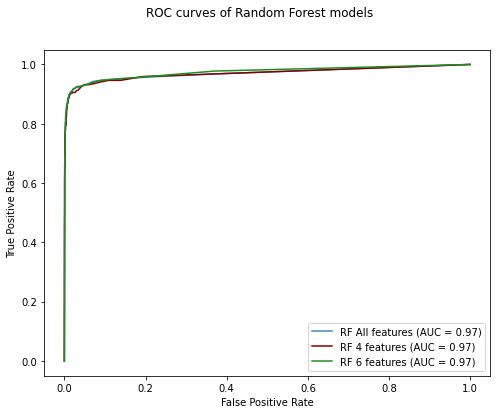

In [27]:
fig, axs = plt.subplots(nrows=1, ncols=1, figsize=(8, 6), sharey='row')
plt.suptitle('ROC curves of Random Forest models')
plot_roc_curve(clf_full, X_test, y_test, color='steelblue', ax=axs, name='RF All features')
plot_roc_curve(clf4, X_test[:, select4], y_test, color='maroon', ax=axs, name='RF 4 features')
plot_roc_curve(clf6, X_test[:, select6], y_test, color='forestgreen', ax=axs, name='RF 6 features')
plt.show()

The model with the highest recall is a Random forest classifier with 4 features.   
I will try to further improve with hyperparameter tunning.

In [28]:
X_train_4, X_test_4 = X_train[:, select4], X_test[:, select4]

param_grid = {#'min_samples_leaf':[1,2,3,4,5,6],
              #'min_samples_split':[2,3,4,5],
              'n_estimators': range(20,181,10)}

clf = RandomForestClassifier()
grid = GridSearchCV(clf, param_grid, cv=5, verbose=10)
grid.fit(X_train_4, y_train)

Fitting 5 folds for each of 17 candidates, totalling 85 fits
[CV] n_estimators=20 .................................................
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[CV] ..................... n_estimators=20, score=0.978, total=   1.3s
[CV] n_estimators=20 .................................................
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.2s remaining:    0.0s
[CV] ..................... n_estimators=20, score=0.977, total=   1.1s
[CV] n_estimators=20 .................................................
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.4s remaining:    0.0s
[CV] ..................... n_estimators=20, score=0.980, total=   1.0s
[CV] n_estimators=20 .................................................
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.3s remaining:    0.0s
[CV] ..................... n_estimators=20, score=0.973, total=   1.0s
[CV] n_estimators=20 .............................

GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid={'n_estimators': range(20, 181, 10)}, verbose=10)

In [29]:
grid.best_estimator_.fit(X_train_4, y_train)
y_hat = grid.predict(X_test_4)

print_metrics(4, 'Hyper parameter tunned random forest classifier', y_test, y_hat)

Using 4 variables, the metrics for the Hyper parameter tunned random forest classifier model are: 
Accuracy 98.14%
Precision 92.34% 
Recall 86.88% 
F1 89.52% 
